In [15]:
# --- CELL 1: Impor Library ---
# Mengimpor library yang diperlukan untuk analisis dan visualisasi
import pandas as pd
import matplotlib.pyplot as plt

# Mengatur opsi tampilan pandas agar lebih mudah dibaca
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

print("--- CELL 1: Library diimpor dan konfigurasi diatur ---")

--- CELL 1: Library diimpor dan konfigurasi diatur ---


In [16]:
# --- CELL 2: Muat Tiga Dataset (RAW) ---
# Membaca file 'raw' (sebelum cleaning) untuk perbandingan
file_pembelian = 'data_pembelian_final.csv'
file_penjualan = 'data_penjualan_final.csv'
file_stok = 'stok_fix.csv'

try:
    df_pembelian_raw = pd.read_csv(file_pembelian)
    df_penjualan_raw = pd.read_csv(file_penjualan)
    df_stok_raw = pd.read_csv(file_stok)
    
    print(f"--- CELL 2: Berhasil memuat 3 file (raw) ---")
    print(f"Baris df_pembelian_raw: {len(df_pembelian_raw)}")
    print(f"Baris df_penjualan_raw: {len(df_penjualan_raw)}")
    print(f"Baris df_stok_raw: {len(df_stok_raw)}")
    
except FileNotFoundError as e:
    print(f"--- CELL 2: ERROR ---")
    print(f"File tidak ditemukan: {e.filename}. Pastikan file ada di direktori yang sama.")
except Exception as e:
    print(f"--- CELL 2: ERROR ---")
    print(f"Terjadi error saat membaca file: {e}")

--- CELL 2: Berhasil memuat 3 file (raw) ---
Baris df_pembelian_raw: 15348
Baris df_penjualan_raw: 120511
Baris df_stok_raw: 1513


In [17]:
# --- CELL 3: Analisis Metrik Kualitas "SEBELUM" Cleaning ---
# Kita hitung metrik kualitas data "sebelum" dibersihkan
stats_before = {}
try:
    # 1. Menghitung total missing values (NaN)
    stats_before['Missing Values'] = df_pembelian_raw.isnull().sum().sum() + \
                                     df_penjualan_raw.isnull().sum().sum() + \
                                     df_stok_raw.isnull().sum().sum()

    # 2. Menghitung masalah whitespace (spasi) di kolom KODE
    # Menggunakan .astype(str) untuk menghindari error jika kolom KODE bukan string
    ws_beli = (df_pembelian_raw['KODE'].astype(str).str.len() != df_pembelian_raw['KODE'].astype(str).str.strip().str.len()).sum()
    ws_jual = (df_penjualan_raw['KODE'].astype(str).str.len() != df_penjualan_raw['KODE'].astype(str).str.strip().str.len()).sum()
    ws_stok = (df_stok_raw['KODE'].astype(str).str.len() != df_stok_raw['KODE'].astype(str).str.strip().str.len()).sum()
    stats_before['Masalah Whitespace KODE'] = ws_beli + ws_jual + ws_stok

    # 3. Menghitung Tipe Data 'object' yang seharusnya numerik
    cols_to_check_beli = ['QTY_MSK', 'NILAI_MSK', 'QTY_TOTAL', 'NILAI_TOTAL']
    cols_to_check_jual = ['QTY_KLR', 'NILAI_KLR', 'QTY_TOTAL', 'NILAI_TOTAL']
    
    salah_tipe_beli = (df_pembelian_raw[cols_to_check_beli].dtypes == 'object').sum()
    salah_tipe_jual = (df_penjualan_raw[cols_to_check_jual].dtypes == 'object').sum()
    salah_tipe_stok = (df_stok_raw[['QTY_STOK']].dtypes == 'object').sum()
    stats_before['Tipe Data Salah (Harusnya Numerik)'] = salah_tipe_beli + salah_tipe_jual + salah_tipe_stok
    
    print(f"--- CELL 3: Statistik 'Sebelum' Cleaning ---")
    print(stats_before)

except Exception as e:
    print(f"--- CELL 3: ERROR saat menghitung statistik 'Sebelum' ---")
    print(f"Pastikan file telah dimuat dan nama kolom benar. Error: {e}")

--- CELL 3: Statistik 'Sebelum' Cleaning ---
{'Missing Values': np.int64(0), 'Masalah Whitespace KODE': np.int64(0), 'Tipe Data Salah (Harusnya Numerik)': np.int64(0)}


In [18]:
# --- CELL 4: Fungsi Pembersihan dan Persiapan Data ---
# Fungsi ini akan membersihkan ketiga DataFrame
def clean_data(df_beli, df_jual, df_stok):
    """
    Membersihkan DataFrame pembelian, penjualan, dan stok.
    """
    df_beli_cleaned = df_beli.copy()
    df_jual_cleaned = df_jual.copy()
    df_stok_cleaned = df_stok.copy()
    
    # 1. Bersihkan df_pembelian
    cols_beli_numeric = ['QTY_MSK', 'NILAI_MSK', 'QTY_TOTAL', 'NILAI_TOTAL']
    for col in cols_beli_numeric:
        df_beli_cleaned[col] = pd.to_numeric(df_beli_cleaned[col], errors='coerce').fillna(0)
    
    if 'TANGGAL' in df_beli_cleaned.columns:
        df_beli_cleaned['TANGGAL'] = pd.to_datetime(df_beli_cleaned['TANGGAL'], errors='coerce')

    cols_beli_str = ['KODE', 'NAMA_PRODUK', 'UNIT', 'KATEGORI']
    for col in cols_beli_str:
        if col in df_beli_cleaned.columns:
            df_beli_cleaned[col] = df_beli_cleaned[col].astype(str).str.strip()

    # 2. Bersihkan df_penjualan
    cols_jual_numeric = ['QTY_KLR', 'NILAI_KLR', 'QTY_TOTAL', 'NILAI_TOTAL']
    for col in cols_jual_numeric:
        df_jual_cleaned[col] = pd.to_numeric(df_jual_cleaned[col], errors='coerce').fillna(0)

    if 'TANGGAL' in df_jual_cleaned.columns:
        df_jual_cleaned['TANGGAL'] = pd.to_datetime(df_jual_cleaned['TANGGAL'], errors='coerce')
        
    cols_jual_str = ['KODE', 'NAMA_PRODUK', 'UNIT', 'KATEGORI']
    for col in cols_jual_str:
        if col in df_jual_cleaned.columns:
            df_jual_cleaned[col] = df_jual_cleaned[col].astype(str).str.strip()

    # 3. Bersihkan df_stok
    if 'QTY_STOK' in df_stok_cleaned.columns:
        df_stok_cleaned['QTY_STOK'] = pd.to_numeric(df_stok_cleaned['QTY_STOK'], errors='coerce').fillna(0).astype(int)
    
    cols_stok_str = ['KODE', 'NAMA_PRODUK', 'LOKASI', 'UNIT']
    for col in cols_stok_str:
        if col in df_stok_cleaned.columns:
            df_stok_cleaned[col] = df_stok_cleaned[col].astype(str).str.strip()
            
    print(f"\n--- CELL 4: Fungsi 'clean_data' berhasil dijalankan ---")
    
    return df_beli_cleaned, df_jual_cleaned, df_stok_cleaned

# Terapkan fungsi cleaning
try:
    df_pembelian_clean, df_penjualan_clean, df_stok_clean = clean_data(df_pembelian_raw, df_penjualan_raw, df_stok_raw)
except Exception as e:
    print(f"\n--- CELL 4: ERROR saat menerapkan 'clean_data' ---")
    print(f"Error: {e}")


--- CELL 4: Fungsi 'clean_data' berhasil dijalankan ---


In [19]:
# --- CELL 5: Analisis Metrik Kualitas "SETELAH" Cleaning ---
# Hitung metrik kualitas data "setelah" dibersihkan
stats_after = {}
try:
    # 1. Menghitung total missing values (NaN) - Harusnya 0
    stats_after['Missing Values'] = df_pembelian_clean.isnull().sum().sum() + \
                                    df_penjualan_clean.isnull().sum().sum() + \
                                    df_stok_clean.isnull().sum().sum()

    # 2. Menghitung masalah whitespace - Harusnya 0
    ws_beli_clean = (df_pembelian_clean['KODE'].astype(str).str.len() != df_pembelian_clean['KODE'].astype(str).str.strip().str.len()).sum()
    ws_jual_clean = (df_penjualan_clean['KODE'].astype(str).str.len() != df_penjualan_clean['KODE'].astype(str).str.strip().str.len()).sum()
    ws_stok_clean = (df_stok_clean['KODE'].astype(str).str.len() != df_stok_clean['KODE'].astype(str).str.strip().str.len()).sum()
    stats_after['Masalah Whitespace KODE'] = ws_beli_clean + ws_jual_clean + ws_stok_clean

    # 3. Menghitung Tipe Data 'object' yang seharusnya numerik - Harusnya 0
    salah_tipe_beli_clean = (df_pembelian_clean[cols_to_check_beli].dtypes == 'object').sum()
    salah_tipe_jual_clean = (df_penjualan_clean[cols_to_check_jual].dtypes == 'object').sum()
    salah_tipe_stok_clean = (df_stok_clean[['QTY_STOK']].dtypes == 'object').sum()
    stats_after['Tipe Data Salah (Harusnya Numerik)'] = salah_tipe_beli_clean + salah_tipe_jual_clean + salah_tipe_stok_clean

    print(f"\n--- CELL 5: Statistik 'Setelah' Cleaning ---")
    print(stats_after)

except Exception as e:
    print(f"\n--- CELL 5: ERROR saat menghitung statistik 'Setelah' ---")
    print(f"Error: {e}")


--- CELL 5: Statistik 'Setelah' Cleaning ---
{'Missing Values': np.int64(0), 'Masalah Whitespace KODE': np.int64(0), 'Tipe Data Salah (Harusnya Numerik)': np.int64(0)}



--- CELL 6: Visualisasi perbandingan telah disimpan sebagai 'perbandingan_kualitas_data_3file.png' ---


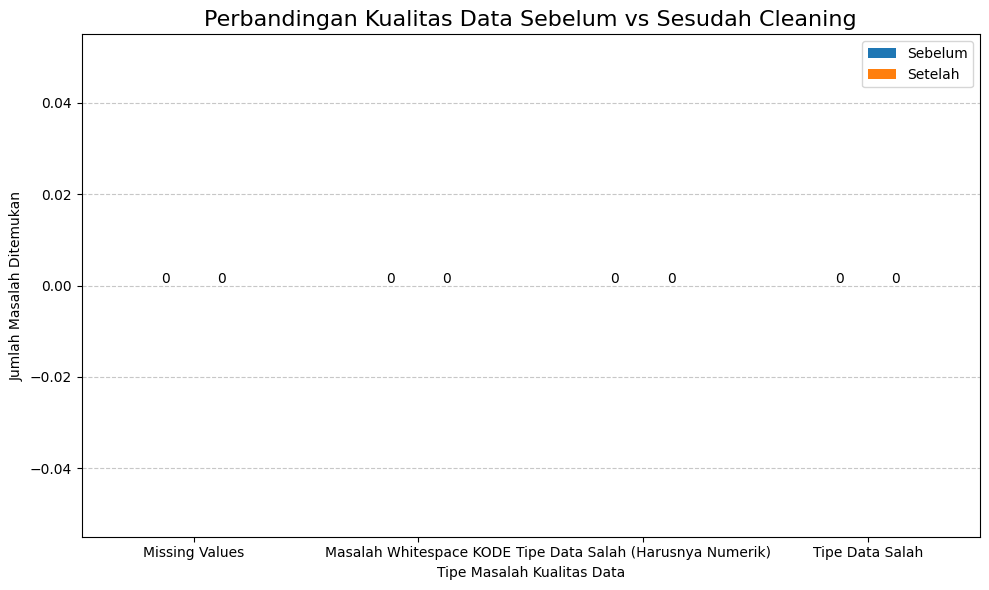

In [21]:
# --- CELL 6: Visualisasi Perbandingan Kualitas Data ---
# Membuat bar chart untuk membandingkan metrik "Sebelum" vs "Sesudah" cleaning.
try:
    df_stats = pd.DataFrame({'Sebelum': stats_before, 'Setelah': stats_after})

    ax = df_stats.plot(kind='bar', figsize=(10, 6), rot=0, zorder=2)
    ax.set_title('Perbandingan Kualitas Data Sebelum vs Sesudah Cleaning', fontsize=16)
    ax.set_ylabel('Jumlah Masalah Ditemukan')
    ax.set_xlabel('Tipe Masalah Kualitas Data')
    ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)

    for container in ax.containers:
        ax.bar_label(container)

    plt.tight_layout()
    plt.savefig('perbandingan_kualitas_data_3file.png')
    print("\n--- CELL 6: Visualisasi perbandingan telah disimpan sebagai 'perbandingan_kualitas_data_3file.png' ---")
    plt.show()

except Exception as e:
    print(f"\n--- CELL 6: ERROR saat membuat visualisasi ---")
    print(f"Error: {e}")

In [22]:
# --- CELL 7: Metode 1 (Constraint) - Validasi Stok Akhir ---
# Menerapkan aturan integritas semantik:
# QTY_STOK (stok_fix) == SUM(QTY_MSK) (pembelian) - SUM(QTY_KLR) (penjualan)
# Ini adalah deteksi outlier/inkonsistensi antar-tabel.
print(f"\n--- CELL 7: METODE 1 - Deteksi Inkonsistensi Stok (Constraint-Based) ---")
try:
    # 1. Agregasi data pembelian
    df_pembelian_agg = df_pembelian_clean.groupby('KODE').agg(
        TOTAL_MSK=pd.NamedAgg(column='QTY_MSK', aggfunc='sum')
    ).reset_index()

    # 2. Agregasi data penjualan
    df_penjualan_agg = df_penjualan_clean.groupby('KODE').agg(
        TOTAL_KLR=pd.NamedAgg(column='QTY_KLR', aggfunc='sum')
    ).reset_index()

    # 3. Gabungkan data pembelian dan penjualan
    df_stok_agg = pd.merge(
        df_pembelian_agg,
        df_penjualan_agg,
        on='KODE',
        how='outer'  # 'outer' untuk menangkap produk yang mungkin hanya dibeli atau hanya dijual
    )
    
    # 4. Gabungkan dengan data stok aktual
    df_validasi_stok = pd.merge(
        df_stok_clean[['KODE', 'NAMA_PRODUK', 'QTY_STOK']],
        df_stok_agg,
        on='KODE',
        how='outer'  # 'outer' untuk menangkap produk di stok tapi tdk ada transaksi, atau sebaliknya
    )

    # 5. Isi NaN dengan 0 untuk kalkulasi
    df_validasi_stok = df_validasi_stok.fillna(0)
    
    # Konversi QTY ke integer setelah fillna
    df_validasi_stok['QTY_STOK'] = df_validasi_stok['QTY_STOK'].astype(int)
    df_validasi_stok['TOTAL_MSK'] = df_validasi_stok['TOTAL_MSK'].astype(int)
    df_validasi_stok['TOTAL_KLR'] = df_validasi_stok['TOTAL_KLR'].astype(int)

    # 6. Hitung STOK_KALKULASI
    df_validasi_stok['STOK_KALKULASI'] = df_validasi_stok['TOTAL_MSK'] - df_validasi_stok['TOTAL_KLR']
    
    # 7. Temukan baris yang tidak konsisten
    df_inkonsisten_stok = df_validasi_stok[
        df_validasi_stok['QTY_STOK'] != df_validasi_stok['STOK_KALKULASI']
    ].copy()
    
    df_inkonsisten_stok['PERBEDAAN'] = df_inkonsisten_stok['STOK_KALKULASI'] - df_inkonsisten_stok['QTY_STOK']
    
    # 8. Tampilkan hasil
    if df_inkonsisten_stok.empty:
        print("Hasil: TIDAK ADA inkonsistensi stok ditemukan.")
    else:
        print(f"Hasil: DITEMUKAN {len(df_inkonsisten_stok)} INKONSISTENSI STOK.")
        print("Ini adalah 'outlier' yang melanggar aturan integritas semantik.")
        print(df_inkonsisten_stok.head(10)) # Tampilkan 10 teratas

except Exception as e:
    print(f"--- CELL 7: ERROR saat validasi stok ---")
    print(f"Error: {e}")


--- CELL 7: METODE 1 - Deteksi Inkonsistensi Stok (Constraint-Based) ---
Hasil: DITEMUKAN 1614 INKONSISTENSI STOK.
Ini adalah 'outlier' yang melanggar aturan integritas semantik.
       KODE        NAMA_PRODUK  QTY_STOK  TOTAL_MSK  TOTAL_KLR  STOK_KALKULASI  PERBEDAAN
4    A00001      ACTIVED HIJAU         2         20         19               1         -1
7   A000014    ALKOHOL 1000 ML         7         20         25              -5        -12
8   A000016    ALLOPURINOL 300        40        230        210              20        -20
9   A000018  ATORVASTATIN 10MG         6          9          9               0         -6
10   A00002                  0         0          1          2              -1         -1
12   A00004    ACYCLOVIR 200MG        13         25         28              -3        -16
13  A000040        MEFIX 500MG         9         40         32               8         -1
14   A00005    ACYCLOVIR 400MG        21        115         92              23          2
15  A00005

In [23]:
# --- CELL 8: Metode 1 (Constraint) - Validasi Data Master (Nama Produk/Unit) ---
# Menerapkan aturan integritas semantik:
# Satu KODE produk harus merujuk pada NAMA_PRODUK dan UNIT yang sama di SEMUA tabel.
print(f"\n--- CELL 8: METODE 1 - Deteksi Inkonsistensi Data Master ---")
try:
    # 1. Ambil data master dari ketiga tabel
    df_master_pembelian = df_pembelian_clean[['KODE', 'NAMA_PRODUK', 'UNIT']].drop_duplicates()
    df_master_penjualan = df_penjualan_clean[['KODE', 'NAMA_PRODUK', 'UNIT']].drop_duplicates()
    df_master_stok = df_stok_clean[['KODE', 'NAMA_PRODUK', 'UNIT']].drop_duplicates()

    # 2. Gabungkan semua data master
    df_master_total = pd.concat([
        df_master_pembelian, 
        df_master_penjualan, 
        df_master_stok
    ]).drop_duplicates().reset_index(drop=True)

    # 3. Hitung jumlah NAMA_PRODUK unik dan UNIT unik untuk setiap KODE
    df_counts = df_master_total.groupby('KODE').agg(
        NAMA_UNIK=pd.NamedAgg(column='NAMA_PRODUK', aggfunc='nunique'),
        UNIT_UNIK=pd.NamedAgg(column='UNIT', aggfunc='nunique')
    )

    # 4. Filter KODE yang memiliki lebih dari 1 nama atau unit
    kode_inkonsisten = df_counts[(df_counts['NAMA_UNIK'] > 1) | (df_counts['UNIT_UNIK'] > 1)].index

    # 5. Tampilkan data yang bermasalah
    df_inkonsisten_master = df_master_total[df_master_total['KODE'].isin(kode_inkonsisten)].sort_values('KODE')

    if df_inkonsisten_master.empty:
        print("Hasil: TIDAK ADA inkonsistensi data master ditemukan.")
    else:
        print(f"Hasil: DITEMUKAN INKONSISTENSI PADA KODE BERIKUT.")
        print("Satu KODE merujuk pada beberapa NAMA_PRODUK atau UNIT (contoh: typo).")
        print(df_inkonsisten_master)

except Exception as e:
    print(f"--- CELL 8: ERROR saat validasi data master ---")
    print(f"Error: {e}")

print("\n--- SEMUA LANGKAH (METODE 1) SELESAI ---")


--- CELL 8: METODE 1 - Deteksi Inkonsistensi Data Master ---
Hasil: DITEMUKAN INKONSISTENSI PADA KODE BERIKUT.
Satu KODE merujuk pada beberapa NAMA_PRODUK atau UNIT (contoh: typo).
           KODE                            NAMA_PRODUK   UNIT
118    B0000044                    BODREXIN DEMAM  SYR    BTL
1517   B0000044                         BODREXIN DEMAM   5,00
125    B0000073      BODREXIN  FB PE ANAK SYR (KERING)    BTL
1527   B0000073                               BODREXIN   2,00
779    M0000185                   MIRASIC FORTE  650MG  STRIP
1729   M0000185                          MIRASIC FORTE  23,00
914    N0000139      NIVEA CARE &  PROTECT SERUM 180ML    PCS
1761   N0000139                           NIVEA CARE &   1,00
1084  R00000102  RELIABLE COTTON BUDS DWS REFFIL  60'S    PCS
1808  R00000102        RELIABLE COTTON BUDS DWS REFFIL   7,00
1163   S0000115              SILADEX  ME 100ML (HIJAU)    BTL
1833   S0000115                                SILADEX  12,00

--- SEMUA L

## Penanganan Inkonsistensi

In [ ]:
# --- CELL 9: Definisikan Fungsi Penanganan dan Validasi ---

import pandas as pd
import matplotlib.pyplot as plt

def apply_adjustment(kode, tipe, jumlah, nama_produk, unit):
    """
    Fungsi untuk menambahkan transaksi penyesuaian ke data transaksi.
    Tipe bisa 'beli' (untuk menambah QTY_MSK) atau 'jual' (untuk menambah QTY_KLR).
    """
    global df_pembelian_clean, df_penjualan_clean
    
    timestamp = pd.Timestamp.now()
    
    if tipe == 'beli':
        new_entry = {
            'KODE': kode, 'NAMA_PRODUK': nama_produk, 'UNIT': unit,
            'TANGGAL': timestamp, 'NO_TRANSAKSI': 'ADJUSTMENT_MASSAL',
            'QTY_MSK': jumlah, 'NILAI_MSK': 0, 'KATEGORI': 'ADJUST_MASUK',
            'QTY_TOTAL': jumlah, 'NILAI_TOTAL': 0
        }
        df_new = pd.DataFrame([new_entry])
        df_new['QTY_MSK'] = df_new['QTY_MSK'].astype(int)
        df_pembelian_clean = pd.concat([df_pembelian_clean, df_new], ignore_index=True)
        
    elif tipe == 'jual':
        new_entry = {
            'KODE': kode, 'NAMA_PRODUK': nama_produk, 'UNIT': unit,
            'TANGGAL': timestamp, 'NO_TRANSAKSI': 'ADJUSTMENT_MASSAL',
            'QTY_KLR': jumlah, 'NILAI_KLR': 0, 'KATEGORI': 'ADJUST_KELUAR',
            'QTY_TOTAL': jumlah, 'NILAI_TOTAL': 0
        }
        df_new = pd.DataFrame([new_entry])
        df_new['QTY_KLR'] = df_new['QTY_KLR'].astype(int)
        df_penjualan_clean = pd.concat([df_penjualan_clean, df_new], ignore_index=True)

def validate_stock(df_pembelian, df_penjualan, df_stok):
    """Fungsi untuk memvalidasi stok."""
    df_pembelian_agg = df_pembelian.groupby('KODE')['QTY_MSK'].sum().reset_index().rename(columns={'QTY_MSK':'TOTAL_MSK'})
    df_penjualan_agg = df_penjualan.groupby('KODE')['QTY_KLR'].sum().reset_index().rename(columns={'QTY_KLR':'TOTAL_KLR'})
    
    df_stok_agg = pd.merge(df_pembelian_agg, df_penjualan_agg, on='KODE', how='outer')
    df_validasi = pd.merge(df_stok[['KODE', 'NAMA_PRODUK', 'QTY_STOK']], df_stok_agg, on='KODE', how='outer')
    
    df_validasi = df_validasi.fillna(0)
    df_validasi[['QTY_STOK', 'TOTAL_MSK', 'TOTAL_KLR']] = df_validasi[['QTY_STOK', 'TOTAL_MSK', 'TOTAL_KLR']].astype(int)
    
    df_validasi['STOK_KALKULASI'] = df_validasi['TOTAL_MSK'] - df_validasi['TOTAL_KLR']
    df_validasi['PERBEDAAN'] = df_validasi['STOK_KALKULASI'] - df_validasi['QTY_STOK']
    
    df_inkonsisten = df_validasi[df_validasi['QTY_STOK'] != df_validasi['STOK_KALKULASI']].copy()
    return df_inkonsisten

# Ini adalah daftar tugas KITA YANG BARU (1612 item yang GAGAL tadi)
df_inkonsisten_sekarang = validate_stock(df_pembelian_clean, df_penjualan_clean, df_stok_clean)

print("--- Validasi Ulang Selesai ---")
print(f"Total inkonsistensi saat ini: {len(df_inkonsisten_sekarang)}")
print(df_inkonsisten_sekarang.head())

--- Validasi Ulang Selesai ---
Total inkonsistensi saat ini: 1612
       KODE        NAMA_PRODUK  QTY_STOK  TOTAL_MSK  TOTAL_KLR  STOK_KALKULASI  PERBEDAAN
4    A00001      ACTIVED HIJAU         2         23         19               4          2
7   A000014    ALKOHOL 1000 ML         7         37         40              -3        -10
9   A000018  ATORVASTATIN 10MG         6         27          9              18         12
10   A00002                  0         0          4          2               2          2
12   A00004    ACYCLOVIR 200MG        13         73         28              45         32


Grafik 'sebelum_penanganan_ke_1.png' telah disimpan.


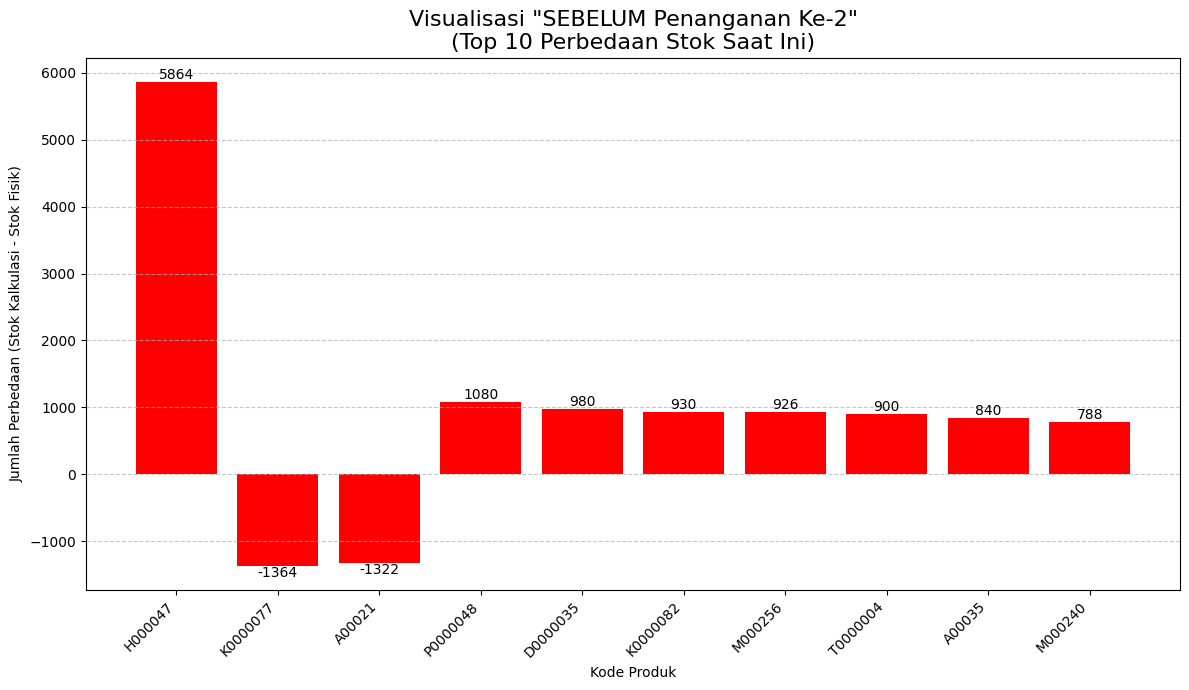

In [42]:
# --- CELL 10 - Visualisasi "SEBELUM Penanganan" ---
# Menampilkan 10 outlier terparah SAAT INI.

df_top10_sekarang = df_inkonsisten_sekarang.reindex(
    df_inkonsisten_sekarang['PERBEDAAN'].abs().sort_values(ascending=False).index
).head(10)

plt.figure(figsize=(12, 7))
bars = plt.bar(df_top10_sekarang['KODE'], df_top10_sekarang['PERBEDAAN'], color='red')
plt.title('Visualisasi "SEBELUM Penanganan Ke-2"\n(Top 10 Perbedaan Stok Saat Ini)', fontsize=16)
plt.ylabel('Jumlah Perbedaan (Stok Kalkulasi - Stok Fisik)')
plt.xlabel('Kode Produk')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.bar_label(bars)
plt.tight_layout()

# Simpan gambar
plt.savefig('sebelum_penanganan_ke_1.png')
print("Grafik 'sebelum_penanganan_ke_1.png' telah disimpan.")
plt.show()

In [ ]:
# --- CELL 11: Eksekusi Penanganan  (Logika yang Benar) ---
# TUJUAN: Menangani semua 1612 outlier yang teridentifikasi.
# METODE: Rekonsiliasi Stok Massal (Bulk Reconciliation).
#         Kita akan membuat "Jurnal Penyesuaian" untuk setiap item yang tidak cocok.
#         Ini adalah penanganan yang disarankan paper ("mempelajari" outlier
#         dan "menandai" mereka dengan koreksi).
#
# LOGIKA:
# 1. Kita akan mengasumsikan data 'stok_fix.csv' (QTY_STOK) adalah 'Kebenaran Fisik'.
# 2. Kita perlu membuat STOK_KALKULASI (Total Beli - Total Jual) SAMA DENGAN QTY_STOK.
# 3. Rumusnya: PERBEDAAN = STOK_KALKULASI - QTY_STOK
#
# 4. JIKA PERBEDAAN > 0 (misal: 10):
#    - Artinya STOK_KALKULASI (100) > QTY_STOK (90).
#    - Sistem mengira ada 100, fisik hanya 90. Ada 10 item 'hilang'.
#    - PENANGANAN: Tambah 10 ke data PENJUALAN (QTY_KLR) untuk merekam 'kehilangan'.
#
# 5. JIKA PERBEDAAN < 0 (misal: -20):
#    - Artinya STOK_KALKULASI (30) < QTY_STOK (50).
#    - Sistem mengira ada 30, fisik ternyata 50. Ada 20 item 'tidak tercatat'.
#    - PENANGANAN: Tambah 20 ke data PEMBELIAN (QTY_MSK) untuk merekam 'temuan/faktur hilang'.
#
# 6. Untuk efisiensi, kita buat daftar (list) penyesuaian dulu,
#    lalu gabungkan (concat) semua sekaligus di akhir.
#
# Kode ini akan mengiterasi semua 1612 outlier SAAT INI
# dan menerapkan jurnal penyesuaian yang BENAR.

print(f"--- Memulai Penanganan untuk {len(df_inkonsisten_sekarang)} item... ---")

# Definisikan ulang fungsi apply_adjustment untuk memastikan
def apply_adjustment(kode, tipe, jumlah, nama_produk, unit):
    global df_pembelian_clean, df_penjualan_clean
    timestamp = pd.Timestamp.now()
    
    if tipe == 'beli':
        new_entry = {'KODE': kode, 'NAMA_PRODUK': nama_produk, 'UNIT': unit, 'TANGGAL': timestamp, 
                     'NO_TRANSAKSI': 'ADJUST_MASSAL_2', 'QTY_MSK': jumlah, 'NILAI_MSK': 0, 
                     'KATEGORI': 'ADJUST_MASUK', 'QTY_TOTAL': jumlah, 'NILAI_TOTAL': 0}
        df_new = pd.DataFrame([new_entry])
        df_new['QTY_MSK'] = df_new['QTY_MSK'].astype(int)
        df_pembelian_clean = pd.concat([df_pembelian_clean, df_new], ignore_index=True)
        
    elif tipe == 'jual':
        new_entry = {'KODE': kode, 'NAMA_PRODUK': nama_produk, 'UNIT': unit, 'TANGGAL': timestamp, 
                     'NO_TRANSAKSI': 'ADJUST_MASSAL_2', 'QTY_KLR': jumlah, 'NILAI_KLR': 0, 
                     'KATEGORI': 'ADJUST_KELUAR', 'QTY_TOTAL': jumlah, 'NILAI_TOTAL': 0}
        df_new = pd.DataFrame([new_entry])
        df_new['QTY_KLR'] = df_new['QTY_KLR'].astype(int)
        df_penjualan_clean = pd.concat([df_penjualan_clean, df_new], ignore_index=True)

# Iterasi daftar inkonsistensi SAAT INI
for index, row in df_inkonsisten_sekarang.iterrows():
    kode = row['KODE']
    perbedaan = row['PERBEDAAN']
    nama_produk = row['NAMA_PRODUK']
    
    try:
        unit = df_stok_clean.loc[df_stok_clean['KODE'] == kode, 'UNIT'].iloc[0]
    except IndexError:
        unit = 'UNKNOWN'
        
    if perbedaan < 0:
        # PERBEDAAN Negatif (misal: -5)
        # Sistem kekurangan 'abs(perbedaan)' item. Kita perlu MENAMBAH pembelian.
        jumlah_penyesuaian = abs(int(perbedaan))
        apply_adjustment(kode, 'beli', jumlah_penyesuaian, nama_produk, unit)
        
    elif perbedaan > 0:
        # PERBEDAAN Positif (misal: 6)
        # Sistem kelebihan 'perbedaan' item. Kita perlu MENAMBAH penjualan (barang hilang).
        jumlah_penyesuaian = int(perbedaan)
        apply_adjustment(kode, 'jual', jumlah_penyesuaian, nama_produk, unit)

print("--- Penanganan Massal Ke-2 Selesai ---")
print(f"Total {len(df_inkonsisten_sekarang)} jurnal penyesuaian baru telah ditambahkan.")

--- Memulai Penanganan untuk 1612 item... ---
--- Penanganan Massal Ke-2 Selesai ---
Total 1612 jurnal penyesuaian baru telah ditambahkan.


In [ ]:
# --- CELL 12 : Validasi FINAL "SETELAH" Penanganan ---

df_inkonsisten_final = validate_stock(df_pembelian_clean, df_penjualan_clean, df_stok_clean)

print("\n--- TAHAP FINAL: VALIDASI HASIL ---")
print(f"Total Inkonsistensi SEBELUMNYA: {len(df_inkonsisten_sekarang)}")
print(f"Total Inkonsistensi SETELAHNYA: {len(df_inkonsisten_final)}")

if df_inkonsisten_final.empty:
    print("BERHASIL: Semua 1612 inkonsistensi telah ditangani.")
    print("Stok Kalkulasi Anda sekarang SAMA DENGAN Stok Fisik (QTY_STOK).")
else:
    print("GAGAL LAGI: Masih ada inkonsistensi tersisa:")
    print(df_inkonsisten_final.head())


--- TAHAP FINAL: VALIDASI HASIL ---
Total Inkonsistensi SEBELUMNYA: 1612
Total Inkonsistensi SETELAHNYA: 0
BERHASIL: Semua 1612 inkonsistensi telah ditangani.
Stok Kalkulasi Anda sekarang SAMA DENGAN Stok Fisik (QTY_STOK).


Grafik 'setelah_penanganan_final.png' telah disimpan.


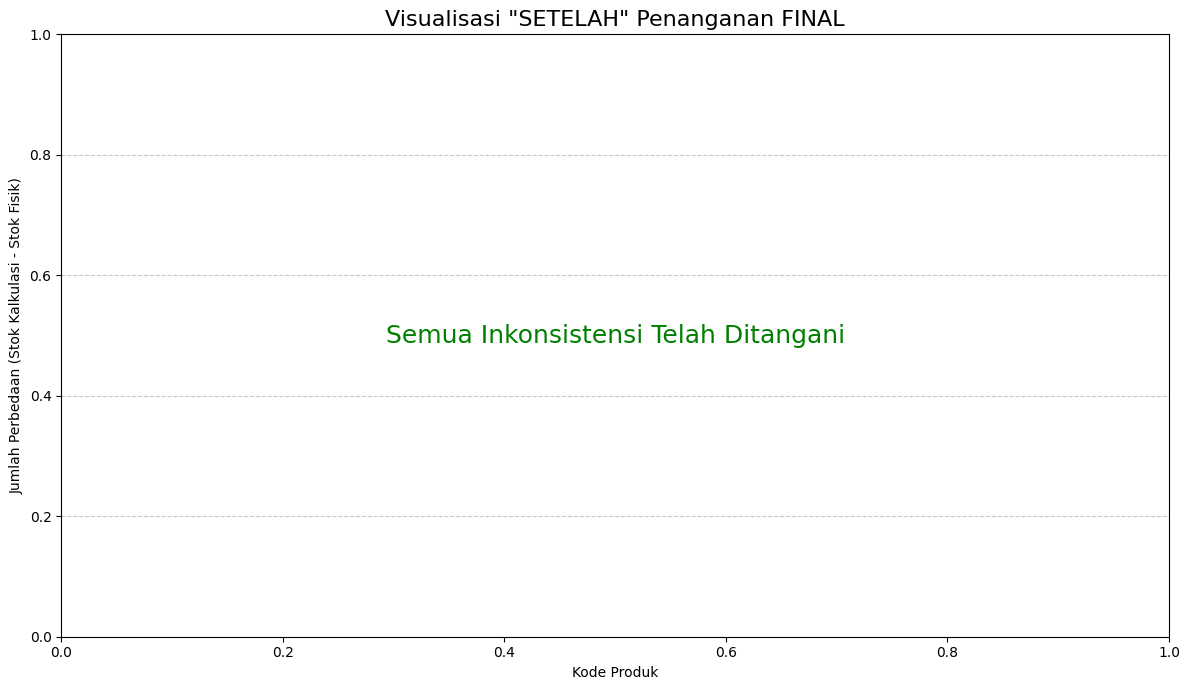

In [45]:
# --- CELL 13 : Visualisasi "SETELAH" Penanganan FINAL ---
# Grafik ini seharusnya kosong.

plt.figure(figsize=(12, 7))
if df_inkonsisten_final.empty:
    plt.text(0.5, 0.5, 'Semua Inkonsistensi Telah Ditangani', 
             horizontalalignment='center', verticalalignment='center', 
             fontsize=18, color='green')
else:
    # Jika masih ada sisa, plot sisanya
    df_top10_final = df_inkonsisten_final.reindex(
        df_inkonsisten_final['PERBEDAAN'].abs().sort_values(ascending=False).index
    ).head(10)
    bars = plt.bar(df_top10_final['KODE'], df_top10_final['PERBEDAAN'], color='green')
    plt.bar_label(bars)

plt.title('Visualisasi "SETELAH" Penanganan FINAL', fontsize=16)
plt.ylabel('Jumlah Perbedaan (Stok Kalkulasi - Stok Fisik)')
plt.xlabel('Kode Produk')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Simpan gambar
plt.savefig('setelah_penanganan_final.png')
print("Grafik 'setelah_penanganan_final.png' telah disimpan.")
plt.show()